# Importing required packages

In [77]:
import spacy
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from spacy.tokens import Doc

from spacy import displacy
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import jsonlines

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#nltk.download(['stopwords','wordnet'])

import sys, fitz

In [78]:
resumes=pd.read_csv("/Users/narendraomprakash/Desktop/Narendra/Semester-V-FALL2021/NLP/J Component/Resume.csv")
resumes=resumes.reindex(np.random.permutation(resumes.index))
data_resumes = resumes.copy().iloc[0:200,]
data_resumes.head()

,ID,Resume_str,Resume_html,Category
1877,39674178,STAFF ACCOUNTANT Executive Summ...,"<div class=""fontsize fontface vmargins hmargin...",ACCOUNTANT
2179,36302399,"BANKING CENTER MANAGER, ASSISTANT VIC...","<div class=""fontsize fontface vmargins hmargin...",BANKING
811,19037403,"PROFESSIONAL FITNESS TRAINER, GROUP I...","<div class=""fontsize fontface vmargins hmargin...",FITNESS
2352,20356750,"ASSISTANT, ACQUISITIONS AND DISPOSITI...","<div class=""fontsize fontface vmargins hmargin...",ARTS
207,51018476,NX (UNIGRAPHICS) DESIGNER Summa...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER


In [79]:
nlp=spacy.load("en_core_web_lg")
skill_pattern_path="/Users/narendraomprakash/Desktop/Narendra/Semester-V-FALL2021/NLP/J Component/jz_skill_patterns.jsonl"

In [80]:
er=nlp.add_pipe("entity_ruler")
er.from_disk(skill_pattern_path)
#nlp.pipe_names

# Skills extraction functions

In [81]:
# Extract skills from text
def get_relevant_skills(text):
    doc=nlp(text)
    skills=[]
    subskills=[]
    for ent in doc.ents:
        if ent.label_=="SKILL":
            subskills.append(ent.text)
    skills.append(subskills)
    return subskills

# Find all unique skills
def unique_skills(x):
    return list(set(x))

# Cleaning functions

In [82]:
cleaned_text = []
for i in range(data_resumes.shape[0]):
    review = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"'," ",data_resumes["Resume_str"].iloc[i],
    )
    review = review.lower()
    review = review.split()
    lm = WordNetLemmatizer() # Lemmatizing
    review = [
        lm.lemmatize(word)
        for word in review
        if not word in set(stopwords.words("english"))
    ]
    review = " ".join(review)
    cleaned_text.append(review)

# Adding Cleaned Text to dataframe

In [83]:
data_resumes["Clean_Resume"] = cleaned_text
data_resumes["skills"] = data_resumes["Clean_Resume"].str.lower().apply(get_relevant_skills)
data_resumes["skills"] = data_resumes["skills"].apply(unique_skills)
data_resumes.head()

,ID,Resume_str,Resume_html,Category,Clean_Resume,skills
1877,39674178,STAFF ACCOUNTANT Executive Summ...,"<div class=""fontsize fontface vmargins hmargin...",ACCOUNTANT,staff accountant executive summary motivated e...,"[support, material, accounting, financial system]"
2179,36302399,"BANKING CENTER MANAGER, ASSISTANT VIC...","<div class=""fontsize fontface vmargins hmargin...",BANKING,banking center manager assistant vice presiden...,"[accounting, business, security, marketing]"
811,19037403,"PROFESSIONAL FITNESS TRAINER, GROUP I...","<div class=""fontsize fontface vmargins hmargin...",FITNESS,professional fitness trainer group instructor ...,"[chrome, accounting, box, business, testing, s..."
2352,20356750,"ASSISTANT, ACQUISITIONS AND DISPOSITI...","<div class=""fontsize fontface vmargins hmargin...",ARTS,assistant acquisition disposition summary acqu...,"[parcel, certificate, finance]"
207,51018476,NX (UNIGRAPHICS) DESIGNER Summa...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER,nx unigraphics designer summary highlight viru...,"[software, documentation, design, front end, d..."


# Visualisation

In [17]:
graph1 = px.histogram(data_resumes, x="Category",title="Distribution of Jobs Categories").update_xaxes(categoryorder="total descending")
graph1.show()

In [84]:
job_categories = data_resumes["Category"].unique()
job_categories = np.append(job_categories,"ALL")

In [85]:
total_skills = []
job_category="TEACHER" # should be taken as input
if job_category != "ALL":
    filtr = data_resumes[data_resumes["Category"] == job_category]["skills"]
    for x in filtr:
        for i in x:
            total_skills.append(i)
else:
    filtr = data_resumes["skills"]
    for x in filtr:
        for i in x:
            total_skills.append(i)

graph2 = px.histogram(
    x=total_skills,
    labels={"x": "Skills"},
    title=f"{job_category} Distribution of Skills",
).update_xaxes(categoryorder="total descending")
graph2.show()

Text(0.5, 1.0, 'Most Used Words in TEACHER Resumes')

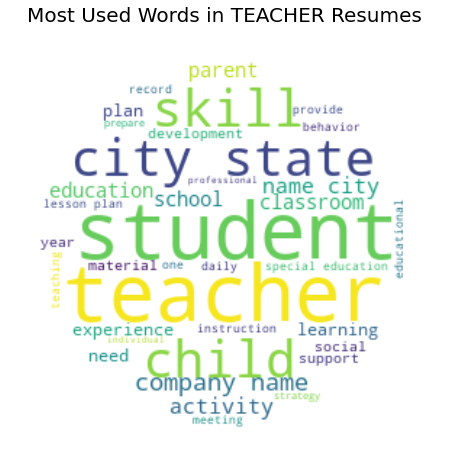

In [23]:
text = ""
for i in data_resumes[data_resumes["Category"] == job_category]["Clean_Resume"].values:
    text+= i + " "

plt.figure(figsize=(8, 8))

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(
    width=800,
    height=800,
    background_color="white",
    min_font_size=6,
    repeat=True,
    mask=mask,
)
wc.generate(text)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title(f"Most Used Words in {job_category} Resumes", fontsize=20)

# Entity Recognition

In [86]:
# Entity Recognition Visualisation
sent=nlp(data_resumes["Resume_str"].iloc[5])
displacy.render(sent, style="ent", jupyter=True)

# Named Entity Recognition

In [87]:
# Adding Job-Category into entity ruler.
# Adding custom colors to all categories.
# Adding gradient colors to SKILL and Job-Category for better visuals

patterns = resumes.Category.unique()
print(patterns)
for a in patterns:
    er.add_patterns([{"label": "Job-Category", "pattern": a}])

['ACCOUNTANT' 'BANKING' 'FITNESS' 'ARTS' 'DESIGNER' 'ENGINEERING' 'SALES'
 'ADVOCATE' 'FINANCE' 'PUBLIC-RELATIONS' 'CONSULTANT' 'CHEF' 'TEACHER'
 'DIGITAL-MEDIA' 'INFORMATION-TECHNOLOGY' 'HR' 'CONSTRUCTION' 'AVIATION'
 'BUSINESS-DEVELOPMENT' 'HEALTHCARE' 'AGRICULTURE' 'BPO' 'APPAREL'
 'AUTOMOBILE']


In [88]:
# Testing NER
colors = {
    "Job-Category": "linear-gradient(90deg, orangered, lightgreen)",
    "SKILL": "linear-gradient(90deg, #9BE15D, #00E3AE)",
    "ORG": "#ffd966",
    "PERSON": "#e06666",
    "GPE": "#9fc5e8",
    "DATE": "#c27ba0",
    "ORDINAL": "#674ea7",
    "PRODUCT": "#f9cb9c",
}
options = {
    "ents": [
        "Job-Category",
        "SKILL",
        "ORG",
        "PERSON",
        "GPE",
        "DATE",
        "ORDINAL",
        "PRODUCT",
    ],
    "colors": colors,
}
sent = nlp(data_resumes["Resume_str"].iloc[0])
displacy.render(sent, style="ent", jupyter=True, options=options)

# Input Resume NER

In [89]:
def pdf2text(input_resume):
    #input_resume="/Users/narendraomprakash/Desktop/Narendra/Narendra G O's Resume.pdf"
    doc = fitz.open(input_resume)
    text = ""
    for page in doc:
        text = text+ str(page.getText())

    tx = " ".join(text.split('\n'))
    return tx
test=pdf2text("/Users/narendraomprakash/Desktop/Narendra/Narendra G O's Resume.pdf")
print(test)
myresume=nlp(test)
displacy.render(myresume, style="ent", jupyter=True, options=options)

Narendra G O go.narendra@outlook.com +918072014549 Education B.Tech, Computer Science and Engineering,  Vellore Institute of Technology, Chennai 2019 – present CGPA: 8.40 Class XII, BVM Global@Perungudi 2017 – 2019 Class X, International Indian School, Al-Jubail 2007 – 2017 CGPA: 8.80 Professional Experience Web Development and Designing Intern, The Sparks Foundation 2021 Developed a static HTML payment gateway using Razorpay testing account, evaluated peer works and provided  suggestions and groomed LinkedIn profile. Skills Programming  Languages C, C++, Python, Java, R Web Development HTML, PHP, Flask, Django Databases MySQL Machine Learning and  Deep Learning Python Projects IPL Score Prediction and Dashboard 06/2021 – 08/2021 Predicted first innings score based on past history of individual team performance. Visualised overall, powerplay, middle-overs and death-overs statistics. Developed as a part of IBM Hack Challenge 2021. Won the Special Jury Award. Home Automation System 02/20

Deprecation:


In [110]:
required_skills="Python,Engineering"
def rankResumes(path):
    resumePaths=[]
    os.chdir(path)  
    for resume in os.listdir():
        if resume.endswith(".pdf"):
            resume_path = f"{path}/{resume}"
            resumePaths.append(resume_path)
    scores={}
    for i in range(0,len(resumePaths)):
        tx=pdf2text(resumePaths[i])
        scores[resumePaths[i]]=candidateMatching(required_skills,tx)
    scores=sorted(scores.items(), key=lambda x: x[1],reverse=True)
    return scores
def candidateMatching(required_skills,tx):
    list_skills = required_skills.lower().split(",")
    resume_skills = unique_skills(get_relevant_skills(tx.lower()))
    score = 0
    for x in list_skills:
        if x in resume_skills:
            score += 1
    req_skills_len = len(list_skills)
    match = round(score / req_skills_len * 100, 1)
    
    return match

print(rankResumes("/Users/narendraomprakash/Downloads/Resumes")) 

Deprecation:
Deprecation:
Deprecation:


[('/Users/narendraomprakash/Downloads/Resumes/jill.pdf', 100.0), ('/Users/narendraomprakash/Downloads/Resumes/ara.pdf', 100.0), ('/Users/narendraomprakash/Downloads/Resumes/dd.pdf', 50.0)]


In [90]:
import os
os.listdir()

['.DS_Store',
 'code.ipynb',
 'Review details.pdf',
 'spacy_code.ipynb',
 'Entity Recognition in Resumes.json',
 'Resume.csv',
 '.ipynb_checkpoints',
 'jz_skill_patterns.jsonl',
 'Research Papers',
 'Review1 TEMPLATE.ppt',
 'Review-1',
 'Review-0']